In [1]:
%load_ext autoreload
%autoreload 2

from scipy.signal import blackmanharris, gaussian
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from phase_transform import PhaseTransform
from pathlib import Path
import keras.backend as K
import keras
from keras.layers import Dense, Concatenate, Lambda
from keras.layers import Input, Reshape, Flatten
from keras.layers import BatchNormalization as BN
from keras.models import Model
from keras.initializers import Orthogonal
from keras.utils import Sequence
from keras_tqdm import TQDMNotebookCallback
from convsep.dataset import LargeDatasetMulti
import numpy as np
from utils import *

traingen = DataGenerator("results/features/train", freq_bins=1025)
validgen = DataGenerator("results/features/valid", freq_bins=1025)

sample_rate = 44100
nfft = 2048
freq_bins = nfft//2+1
time_context = 11
num_epochs = 10
f = np.arange(freq_bins)*sample_rate/nfft
t = np.arange(time_context, dtype=float)/sample_rate*nfft
tt = PhaseTransform(frameSize=nfft, hopSize=1024, sampleRate=sample_rate, window=blackmanharris)

sources = ['vocals','bass','drums','other']
n_sources = len(sources)
channels = ['left', 'right']
n_channels = len(channels)

features_path = Path("/media/pierre-louis/TOSHIBA EXT/.pierre-louis/results/features")
model_dir = "results/models"
os.makedirs(model_dir, exist_ok=True)

Using TensorFlow backend.


I 2019-03-19 22:12:33 dataset:1140 found 55 files


100%|██████████| 55/55 [00:23<00:00,  2.52it/s]

I 2019-03-19 22:12:56 dataset:1154 iteration size 1172


I 2019-03-19 22:13:02 dataset:1140 found 30 files


100%|██████████| 30/30 [00:12<00:00,  2.48it/s]

I 2019-03-19 22:13:15 dataset:1154 iteration size 639


# Visualizing the data
it would be good to reduce to float32 for increasing RAM on RTX 2070

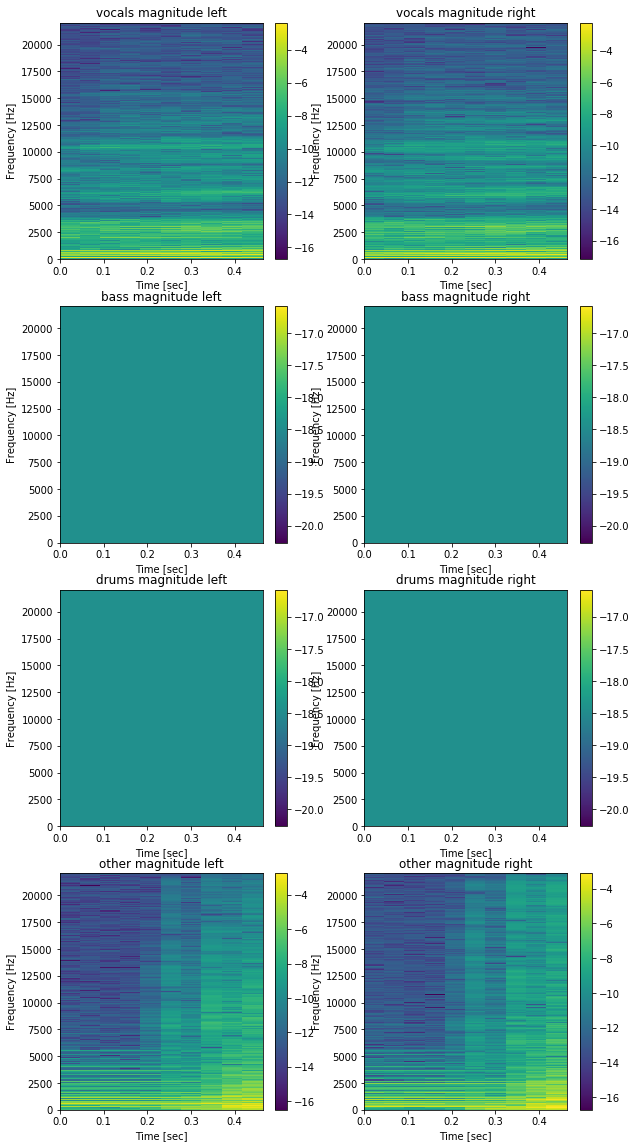

In [2]:
inputs, targets, features = traingen.dataloader()
assert inputs.shape[1] == n_channels
assert inputs.shape[2] == time_context
assert inputs.shape[3] == freq_bins

plt.figure(figsize=(5*n_channels,5*n_sources))
for i, source in enumerate(sources):
    for j, channel in enumerate(channels):
        plt.subplot(n_sources, n_channels, 1+n_channels*i+j)
        logmag = np.log(1e-8+targets[0,n_channels*i+j]).T
        plt.pcolormesh(t[:time_context,], f[:,], logmag[:,:time_context])
        plt.colorbar()
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.title(source + " magnitude " + channel)
plt.show()

# Training

Training the vocals
Instructions for updating:
Colocations handled automatically by placer.
W 2019-03-19 22:13:53 tensorflow:323 From /home/pierre-louis/.pyenv/versions/3.6.7/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
W 2019-03-19 22:13:53 tensorflow:323 From /home/pierre-louis/.pyenv/versions/3.6.7/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


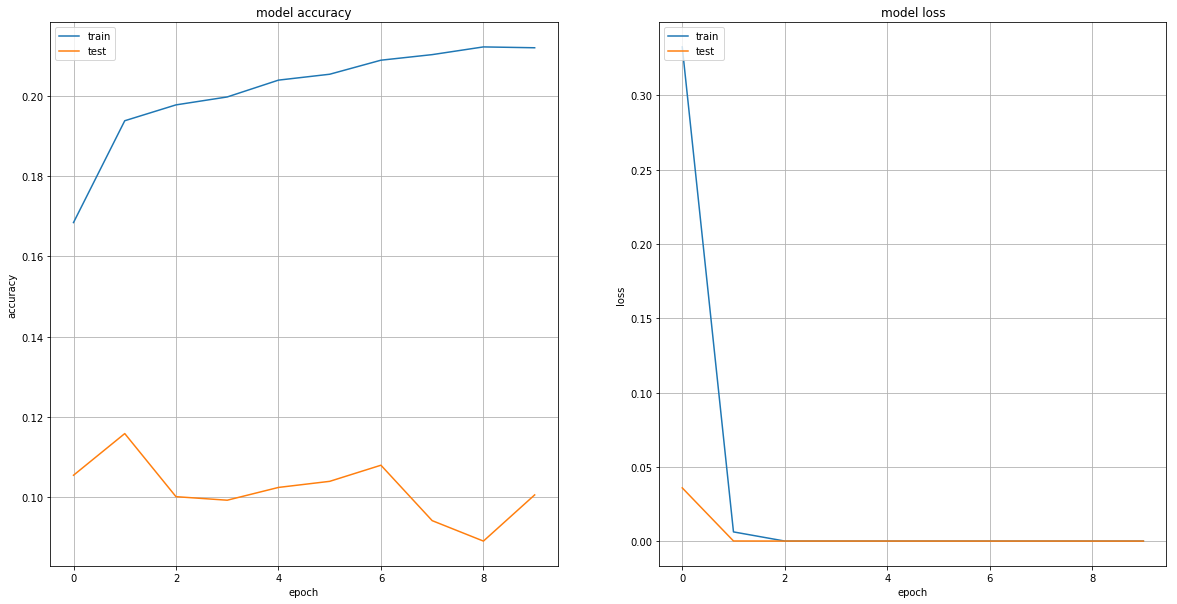

Training the bass


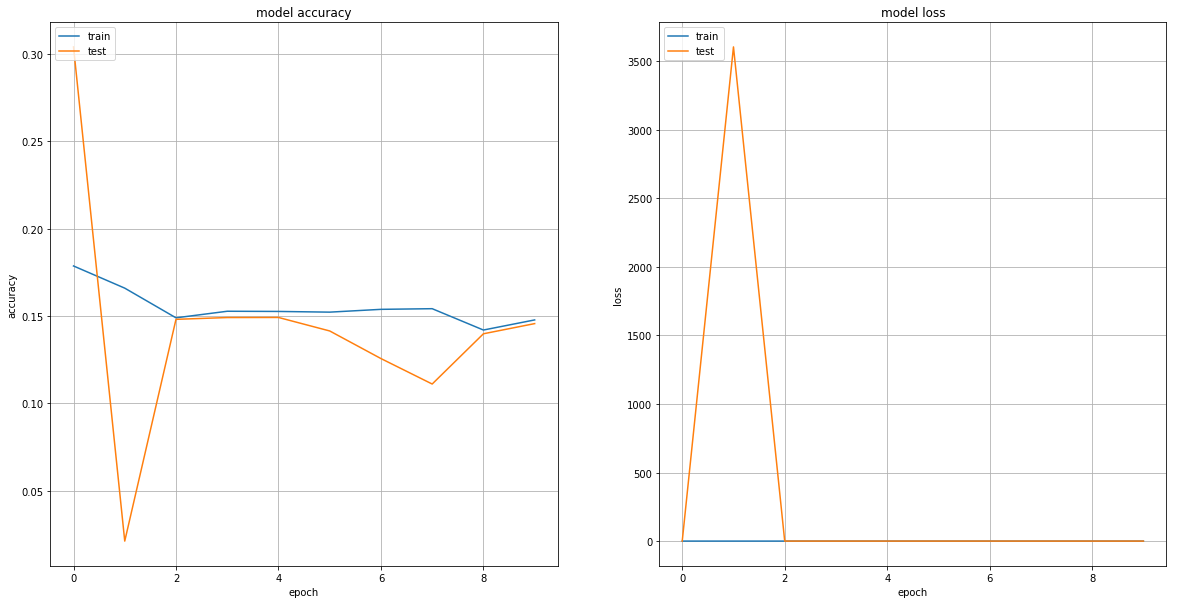

Training the drums


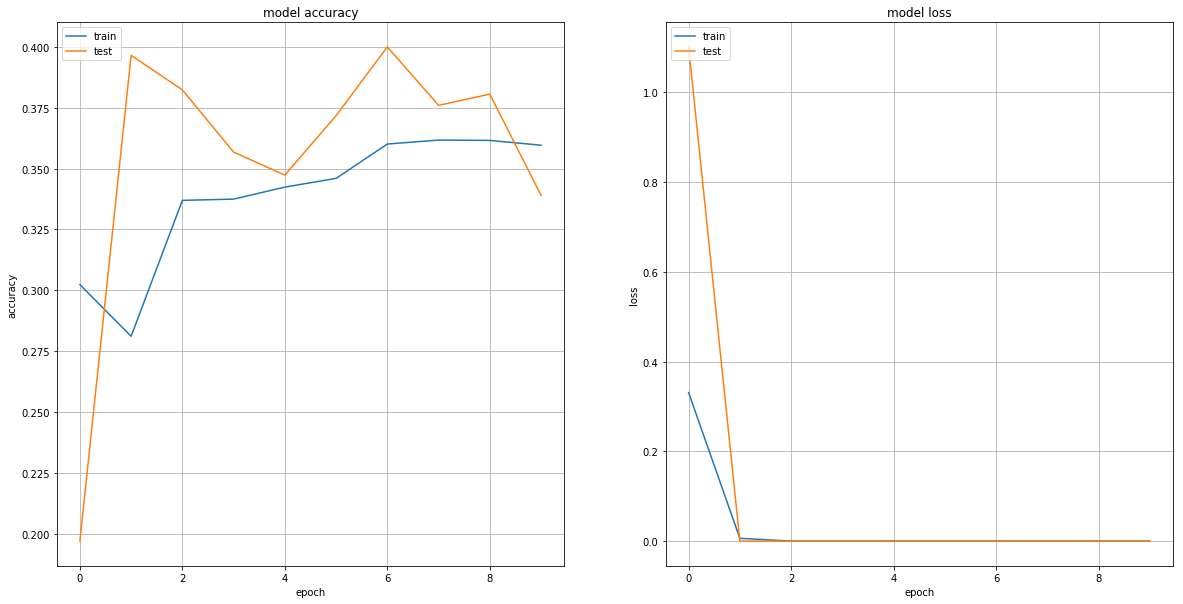

Training the other


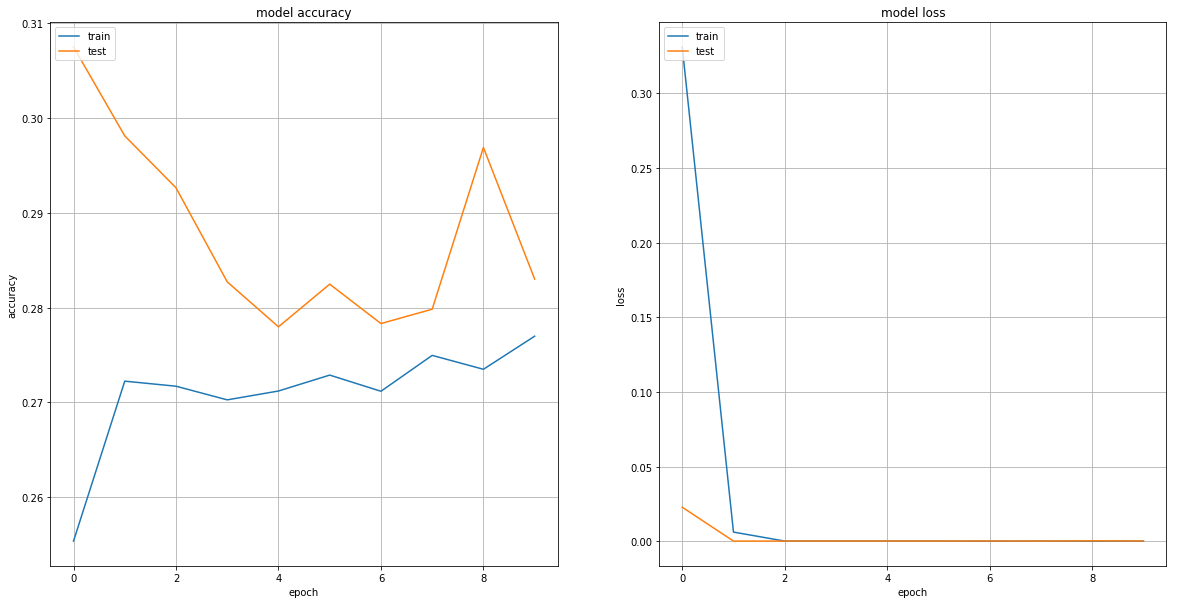

In [4]:
from keras_tqdm import TQDMNotebookCallback
from convsep.dataset import LargeDatasetMulti

histories = []

for i, source in enumerate(sources):
    print("Training the", source)
    model = build_dnn(freq_bins=freq_bins)
    traingen.source_id = i
    validgen.source_id = i
    history = model.fit_generator(traingen, validation_data=validgen, verbose=False,
               epochs=10, use_multiprocessing=False, callbacks=[TQDMNotebookCallback()])
    model.save(source + ".h5")
    del model
    histories.append(history)
    plot_history(history)
    


In [6]:
import pickle
with open("histories.pkl", "wb") as pkl:
    pickle.dump(histories, pkl)

In [108]:
from IPython.display import Audio
from scipy.io import wavfile

raw_gt = tt.compute_inverse(mag_out[:,6,0,:], ph_out[:,2,0,:])
raw_pred = tt.compute_inverse(mag_pred[:,0], ph_in[:,0,0,:])

wavfile.write("./gt.mp3", sample_rate, raw_gt)
# wavfile.write("./pred.mp3", sample_rate, raw_pred)

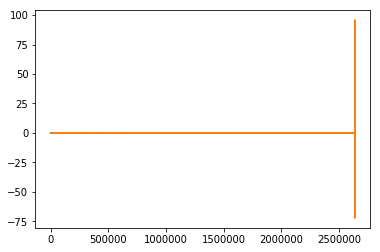

In [104]:
plt.plot(raw_gt)
plt.plot(raw_pred)